In this notebook we focus on a region in the Dominican Republic of Congo where roads have been built into the forest. In the area of interest (AOI) we are using, the roads were built between September and November 2017.

This notebook does the following:
- use PS Orthotiles
- filter by overlap of a set of orthotiles (strips) to an aoi that straddles orthotile grid boundaries
- take advantage of the Cloud-Optimized Geotiffs (COGs) Planet provides to download only the pixels within the AOI
- 

In [199]:
import datetime
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
from planet import api
from planet.api import filters
from shapely import geometry as sgeom
from shapely.ops import cascaded_union

In [78]:
aoi = {"geometry": {
    "type":"Polygon",
    "coordinates":
        [[
            [25.42429478260258,1.0255377823058893],
            [25.592960813580472,1.0255377823058893],
            [25.592960813580472,1.1196578801254304],
            [25.42429478260258,1.1196578801254304],
            [25.42429478260258,1.0255377823058893]
        ]]}}

item_type = 'PSOrthoTile'

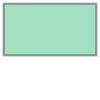

In [79]:
aoi_shape = sgeom.shape(aoi['geometry'])
aoi_shape

In [80]:
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [81]:
# utility functions for searching for scenes that cover the aoi
def build_ps_request(aoi, item_type):
    old = datetime.datetime(year=2017,month=9,day=1)
    new = datetime.datetime(year=2017,month=12,day=1)

    search_aoi = aoi['geometry']
    query = filters.and_filter(
        filters.geom_filter(search_aoi),
        filters.range_filter('cloud_cover', lt=5),
        filters.date_range('acquired', gte=old),
        filters.date_range('acquired', lt=new)
    )

    # build a request for only PlanetScope imagery
    request = filters.build_search_request(
        query, item_types=[item_type]
    )
    
    return request

def get_monthly_stats(client, request):
    stats_request = request.copy()
    stats_request['interval'] = 'month'
    return client.stats(stats_request).get()

print(json.dumps(get_monthly_stats(client, build_ps_request(aoi, item_type)),
      indent=4))

{
    "utc_offset": "+0h",
    "interval": "month",
    "buckets": [
        {
            "count": 50,
            "start_time": "2017-09-01T00:00:00.000000Z"
        },
        {
            "count": 30,
            "start_time": "2017-10-01T00:00:00.000000Z"
        },
        {
            "count": 52,
            "start_time": "2017-11-01T00:00:00.000000Z"
        }
    ]
}


In [86]:
def search_pl_api(client, request, limit=500):
    result = client.quick_search(request)
    
    # note that this returns a generator
    return result.items_iter(limit=limit)

items = list(search_pl_api(client, build_ps_request(aoi, item_type)))
print(len(items))
# uncomment below to see entire metadata for a landsat scene
# print(json.dumps(items[0], indent=4))
del items

132


In [103]:
def items_to_scenes(items):
    item_types = []

    def _get_props(item):
        props = item['properties']
        
        # add data not in properties list
        props.update({
            'thumbnail': item['_links']['thumbnail'],
            'id': item['id'],
            'footprint': item['geometry'],
        })
        return props
    
    scenes = pd.DataFrame(data=[_get_props(i) for i in items])
    
    # convert acquired from string to datetime for processing
    scenes['acquired'] = pd.to_datetime(scenes['acquired'])
    
    return scenes

scenes = items_to_scenes(search_pl_api(client, build_ps_request(aoi, item_type)))
scenes.head()

,acquired,anomalous_pixels,black_fill,cloud_cover,columns,epsg_code,footprint,grid_cell,ground_control,gsd,...,published,rows,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle
0,2017-11-29 08:01:24.074002,0.09,0.03,0.088,8000,32635,"{'coordinates': [[[25.485767058956622, 0.86370...",3539508,True,4.0,...,2017-11-30T02:50:12Z,8000,103e,951008,128.5,52.2,https://tiles.planet.com/data/v1/item-types/PS...,2017-11-30T02:50:12Z,0.88,1.0
1,2017-11-29 08:01:22.491475,0.11,0.68,0.109,8000,32635,"{'coordinates': [[[25.508178377666166, 1.08075...",3539608,True,4.0,...,2017-11-30T02:50:09Z,8000,103e,951008,128.6,52.1,https://tiles.planet.com/data/v1/item-types/PS...,2017-11-30T02:50:09Z,0.21,1.0
2,2017-11-27 08:00:59.379316,0.02,0.20,0.019,8000,32635,"{'coordinates': [[[25.507997207268964, 0.86370...",3539508,True,4.0,...,2017-11-28T00:19:38Z,8000,0f38,945897,128.1,52.5,https://tiles.planet.com/data/v1/item-types/PS...,2017-11-28T06:48:57Z,0.78,1.2
3,2017-11-27 08:00:55.739207,0.02,0.40,0.017,8000,32635,"{'coordinates': [[[25.552338266881225, 1.08080...",3539608,True,4.0,...,2017-11-28T00:19:34Z,8000,0f38,945897,128.3,52.4,https://tiles.planet.com/data/v1/item-types/PS...,2017-11-28T06:48:32Z,0.58,1.2
4,2017-11-27 08:01:54.790807,0.03,0.04,0.027,8000,32635,"{'coordinates': [[[25.27017644110049, 0.863604...",3539507,True,4.0,...,2017-11-27T22:00:04Z,8000,1033,945671,128.0,52.4,https://tiles.planet.com/data/v1/item-types/PS...,2017-11-28T07:05:02Z,0.93,1.0


In [150]:
def aoi_intersection(footprint, aoi):
    aoi_shape = sgeom.shape(aoi['geometry'])
    footprint_shape = sgeom.shape(footprint)
    intersection_shape = aoi_shape.intersection(footprint_shape)
    
    try:
        intersection_percent = 100 * footprint_shape.area / intersection_shape.area
    except ZeroDivisionError:
        intersection_percent = 0

    data = {'intersection_shape': intersection_shape,
            'intersection_fp_perc': intersection_percent}
    return pd.Series(data=data)

intersections = scenes.footprint.apply(aoi_intersection, args=(aoi,))

scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)

In [152]:
# filter out scenes with no intersection
scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
len(scenes_inter)

129

### Strip Overlap

Because the AOI straddles orthotile grid lines, we focus on the overlap between the aoi and the strip (which is what is cut into orthotiles).

We want to filter to strips that have a significant (80%) overlap

In [193]:
def get_strip_aoi_inter(group, aoi):
    '''group: data frame with strip id as index'''
    intersections = group['intersection_shape'].tolist()
    intersection_shape = cascaded_union(intersections)
    aoi_shape = sgeom.shape(aoi['geometry'])

    try:
        intersection_percent = 100 * intersection_shape.area / aoi_shape.area
    except ZeroDivisionError:
        intersection_percent = 0 

    data = {'strip_intersection_shape': intersection_shape,
            'strip_intersection_aoi_perc': intersection_percent}
    return pd.Series(data=data)
    
scenes_sid = scenes_inter.groupby(['strip_id'])
print('{} intersecting strips'.format(len(scenes_sid)))

# with help from: https://stackoverflow.com/a/43616001/2344416
strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=aoi)

47 intersecting strips


In [194]:
strip_aoi_inter.head()

,strip_intersection_shape,strip_intersection_aoi_perc
strip_id,,
736994,"POLYGON ((25.42429478260258 1.059224489085933,...",34.632402
739002,"POLYGON ((25.59296081358047 1.089882591128244,...",8.235740
739199,"POLYGON ((25.49464809563758 1.025537782305889,...",100.000000
741219,"POLYGON ((25.59296081358047 1.089847379752558,...",52.223891
741529,"POLYGON ((25.49464809563758 1.025537782305889,...",99.997564


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4e90f4c50>]],
      dtype=object)

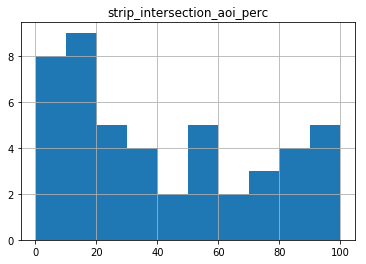

In [195]:
# what does the distribution of intersection percent of aoi look like?
strip_aoi_inter.hist(bins=10)

In [198]:
# filter to strips that have significant overlap
strip_aoi_inter_filt = strip_aoi_inter[strip_aoi_inter.strip_intersection_aoi_perc > 80]
len(strip_aoi_inter_filt)

9